# Bringing MCP into the mix

In [ ]:
# Import necessary libraries
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langchain.agents import create_agent
import nest_asyncio
from langchain_openai import ChatOpenAI

# Apply nest_asyncio to handle nested event loops
nest_asyncio.apply()

In [4]:
import os

# Note this is NOT an production ready MCP server, don't include env variables this way. 
#  I'm doing this so I can work in a notebook
MCP_SERVER = f'''
from mcp.server.fastmcp import FastMCP
from langchain_community.utilities import SerpAPIWrapper
import os

mcp = FastMCP("MCP Example")

@mcp.tool()
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

@mcp.tool()
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b

@mcp.tool()
def google_something(query: str) -> str:
    """Online Realtime Web Search"""
    serpapi = SerpAPIWrapper(serpapi_api_key="{os.getenv("SERPAPI_API_KEY")}")
    return serpapi.run(query)

if __name__ == "__main__":
    mcp.run(transport="stdio")
'''

mcp_path = 'mcp_server.py'

with open(mcp_path, 'w') as f:
    f.write(MCP_SERVER)

print("Saved to:", os.path.abspath(mcp_path))


Saved to: /Users/sinanozdemir/Teaching/Pearson/applied-ai-book/agent_positional_bias/mcp_server.py


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

server_params = StdioServerParameters(
    command="python",
    args=[os.path.abspath(mcp_path)]
)

async def agent_run_async(m):
    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            mcp_tools = await load_mcp_tools(session)
            for tool in mcp_tools:
                print(f'Tool Name: {tool.name}')
                print(f'Tool Description: {tool.description}')
                print(f'Tool Args Schema: {tool.args_schema}')
                print(f'Tool Args : {tool.response_format}')
                print('------')
            agent = create_agent(llm, mcp_tools)
            response = await agent.ainvoke({"messages": m})
            return response

agent_response = await agent_run_async("what's the current price of bitcoin times 12?")

Tool Name: add
Tool Description: Add two numbers
Tool Args Schema: {'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}
Tool Args : content_and_artifact
------
Tool Name: multiply
Tool Description: Multiply two numbers
Tool Args Schema: {'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'multiplyArguments', 'type': 'object'}
Tool Args : content_and_artifact
------
Tool Name: google_something
Tool Description: Online Realtime Web Search
Tool Args Schema: {'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'google_somethingArguments', 'type': 'object'}
Tool Args : content_and_artifact
------


In [6]:
agent_response['messages'][-1]

AIMessage(content="I currently can't access real-time data, including cryptocurrency prices. However, you can easily find the current price of Bitcoin on financial news websites, cryptocurrency exchanges, or financial apps. Once you have that price, I can help you multiply it by 12.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 240, 'total_tokens': 292, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BwEO7VL1CIji88qErw8pmnlfhtp23', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--92f18e3e-1497-49da-a47c-2d27512b0480-0', usage_metadata={'input_tokens': 240, 'output_tokens': 52, 'total_tokens': 292, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [7]:
for message in agent_response['messages']:
    print(type(message), message.content, 'Tool ID:' + message.tool_call_id if hasattr(message, 'tool_call_id') else '')
    if message.additional_kwargs.get('tool_calls'):
        for tool_call in message.additional_kwargs.get('tool_calls'):
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["function"]["name"]}), Args({tool_call["function"]["arguments"]})')
    print('----')

<class 'langchain_core.messages.human.HumanMessage'> what's the current price of bitcoin times 12? 
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(call_beH7wa6A0NMJ6MT5vUrCfAJZ), Name(google_something), Args({"query":"current price of Bitcoin"})
----
<class 'langchain_core.messages.tool.ToolMessage'> Error: ToolException('Error executing tool google_something: Got error from SerpAPI: Invalid API key. Your API key should be here: https://serpapi.com/manage-api-key')
 Please fix your mistakes. Tool ID:call_beH7wa6A0NMJ6MT5vUrCfAJZ
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(call_8rX2fx0ZgqEdamEh3bIBels7), Name(google_something), Args({"query":"current Bitcoin price"})
----
<class 'langchain_core.messages.tool.ToolMessage'> Error: ToolException('Error executing tool google_something: Got error from SerpAPI: Invalid API key. Your API key should be here: https://serpapi.com/manage-api-key')
 Please fix your mistakes. Tool ID:call_8rX2fx0ZgqEdamEh

In [8]:
len(agent_response['messages'])

6

# Testing for Accuracy + Positional Bias

In [ ]:
tool_selection_test_data = [
    ('What is the price of ethereum right now?', 'crypto_and_nft_tool'),
    ('What is the price of bitcoin right now?', 'crypto_and_nft_tool'),
    ('Check the floor price of the world of women nft', 'crypto_and_nft_tool'),
    ('Give me dogecoin price', 'crypto_and_nft_tool'),

    ('Add a new row and just write "To do" in it', 'google_spreadsheet_tool'),
    ('Add this data to the spreadsheet: "1, 2, 3"', 'google_spreadsheet_tool'),
    ('Add: "Sinan, Pearson" to the spreadsheet', 'google_spreadsheet_tool'),
    ('Check the calculated sum of the first column', 'google_spreadsheet_tool'),
    

    ('Go to https://loopgenius.com and tell me about it', 'firecrawl_tool'),
    ('Visit https://github.com/trending and list top repositories', 'firecrawl_tool'),
    ('Scrape the main headlines from https://news.ycombinator.com', 'firecrawl_tool'),
    ('Go to https://en.wikipedia.org/wiki/Python_(programming_language) and summarize the introduction', 'firecrawl_tool'),
    ('Check the documentation at https://pytorch.org and tell me the latest version name', 'firecrawl_tool'),
    ('Visit https://openai.com and summarize the homepage', 'firecrawl_tool'),
    ('What is the headline on https://bbc.com/news', 'firecrawl_tool'),

    ('What are the current gas prices in Chicago?', 'serp_tool'),
    ('Find the intro.co link for Sinan Ozdemir', 'serp_tool'),
    ('What is the release date of the next Marvel movie?', 'serp_tool'),
    ('Who won the latest Super Bowl?', 'serp_tool'),
    ('What are the top restaurants in New York City?', 'serp_tool'),
    ('Get the latest stock price for Apple (AAPL)', 'serp_tool'),
    ('List the top 5 popular programming languages in 2024', 'serp_tool'),
    ('Look up the conversion from 98 degrees Fahrenheit to Celsius on the web', 'serp_tool'),

    ('Convert 98 degrees Fahrenheit to Celsius using Python', 'python_repl_tool'),
    ('Write a function that yields the nth fibonacci number and use it to find the 100th fibonacci number', 'python_repl_tool'),
    ('Calculate the factorial of 10 using Python', 'python_repl_tool'),
    ('Calculate 15% of 34543.453', 'python_repl_tool'),
    ('Convert 42 kilometers to miles using a function in Python', 'python_repl_tool'),
    ('Generate a random number between 1 and 1000', 'python_repl_tool'),
    
    # CRM Contact Tool
    ('Add a new contact named John Smith with email john@example.com', 'crm_contact_tool'),
    ('Search for contacts at Google company', 'crm_contact_tool'),
    ('Update contact ID 123 to change their phone number', 'crm_contact_tool'),
    ('Delete the contact with ID 456', 'crm_contact_tool'),
    ('List all contacts in the CRM system', 'crm_contact_tool'),
    
    # eBay Price Tool
    ('Check the current eBay price for iPhone 15 Pro', 'ebay_price_tool'),
    ('What is the average price of a used MacBook Pro on eBay?', 'ebay_price_tool'),
    ('Find the eBay selling price for vintage Pokemon cards', 'ebay_price_tool'),
    ('Look up the market value of a 2020 Toyota Camry on eBay', 'ebay_price_tool'),
    ('Check eBay prices for refurbished iPad Air', 'ebay_price_tool'),
    
    # Calendar Scheduling Tool
    ('Schedule a meeting for tomorrow at 2 PM', 'calendar_scheduling_tool'),
    ('Show me my calendar for next week', 'calendar_scheduling_tool'),
    ('Update my 3 PM meeting to 4 PM', 'calendar_scheduling_tool'),
    ('Delete the event with ID 789', 'calendar_scheduling_tool'),
    ('Find available time slots for a 2-hour meeting this Friday', 'calendar_scheduling_tool'),
    
    # Email Sender Tool
    ('Send an email to sarah@company.com about the project update', 'email_sender_tool'),
    ('Email the team about tomorrow\'s meeting with agenda attached', 'email_sender_tool'),
    ('Send a follow-up email to the client with the proposal', 'email_sender_tool'),
    ('Email my boss about the vacation request', 'email_sender_tool'),
    ('Send a thank you email to the interview panel', 'email_sender_tool'),
    
    # Social Media Tool
    ('Post "Just finished a great workout!" to Twitter', 'social_media_tool'),
    ('Schedule a LinkedIn post for next Monday about our product launch', 'social_media_tool'),
    ('Delete my Facebook post from yesterday', 'social_media_tool'),
    ('Get analytics for my Instagram post from last week', 'social_media_tool'),
    ('Post a photo to Instagram with hashtags #sunset #nature', 'social_media_tool'),
    
    # Weather Forecast Tool
    ('What\'s the weather like in Miami this weekend?', 'weather_forecast_tool'),
    ('Give me a detailed 7-day forecast for New York City', 'weather_forecast_tool'),
    ('Check the hourly weather for Chicago today', 'weather_forecast_tool'),
    ('What\'s the current temperature in Los Angeles?', 'weather_forecast_tool'),
    ('Get the weather forecast for my location for the next 3 days', 'weather_forecast_tool'),
    
    # File Storage Tool
    ('Upload my resume.pdf to the cloud storage', 'file_storage_tool'),
    ('Download the project files from /work/documents/', 'file_storage_tool'),
    ('Share the presentation.pptx file with read-only access', 'file_storage_tool'),
    ('Move the photos from /personal/ to /archive/', 'file_storage_tool'),
    ('List all files in the /projects/ folder', 'file_storage_tool'),
    
    # Database Query Tool
    ('Select all users from the customers table', 'database_query_tool'),
    ('Insert a new product record into the inventory database', 'database_query_tool'),
    ('Update the price of product ID 123 in the products table', 'database_query_tool'),
    ('Delete all orders older than 2 years from the orders table', 'database_query_tool'),
    ('Create a new table called employee_reviews', 'database_query_tool'),
    
    # Translation Tool
    ('Translate "Hello, how are you?" to Spanish', 'translation_tool'),
    ('Convert this French text to English: "Bonjour, comment allez-vous?"', 'translation_tool'),
    ('Translate the German phrase "Wie geht es dir?" to Italian', 'translation_tool'),
    ('Convert "Thank you very much" to Japanese', 'translation_tool'),
    ('Translate this business email to Portuguese', 'translation_tool'),
    
    # PDF Document Tool
    ('Extract all text from the contract.pdf file', 'pdf_document_tool'),
    ('Merge these 3 PDF files into one document', 'pdf_document_tool'),
    ('Split the large report.pdf into separate chapters', 'pdf_document_tool'),
    ('Convert this PDF to a Word document', 'pdf_document_tool'),
    ('Generate a PDF report from the quarterly data', 'pdf_document_tool'),
]


In [10]:
# TODO sometimes the LLM asks clarifications, and then it never chooses a tool that isn't wrong necessarily.

In [ ]:
import os
import random

# Define tool snippets
tool_snippets = [
    '''
@mcp.tool()
def google_spreadsheet_tool(action: str = "append_to_sheet", **kwargs) -> dict:
    """
    Executes specified actions on the Google Spreadsheet.

    :param action: The action to perform ("append_to_sheet", "search", "insert_into_cell", "get_data_in_range", "describe").
    :Additional arguments for each specific action:
        - "search": 
            "search" will return the row indices where the search_value is found in the column_name.
            Requires 'search_value' and 'column_name'. Example: {"action": "search", "search_value": "John", "column_name": "Name"}
        - "append_to_sheet":
            "append_to_sheet" will append the data to the end of the sheet.
            Requires 'data'. Example: {"action": "append_to_sheet", "data": [["John", "Doe", "john.doe@example.com"], ["Jane", "Smith", "jane.smith@example.com"]]}
        - "insert_into_cell": 
            "insert_into_cell" will insert the value into the specified cell.
            Requires 'value' and 'cell'. Example: {"action": "insert_into_cell", "value": "New Value", "cell": "A1"}
        - "get_data_in_range": 
            "get_data_in_range" will return the data in the specified range.
            Requires 'range_name'. Example: {"action": "get_data_in_range", "range_name": "Sheet1!A1:B2"} or {"action": "get_data_in_range",    "range_name": "Contacts!A12:G28"}
        - "describe": 
            "describe" will return the number of columns and rows in the sheet.
            No additional arguments. Example: {"action": "describe"}
    :return: The result of the operation.
    """
    return f"Fake response for google spreadsheet operation: {action}"
''',
    '''
@mcp.tool()
def crypto_and_nft_tool(query: str) -> str:
    """Get current cryptocurrency prices and NFT prices around the world and for a specific wallet.
    :param query: The query to search for cryptocurrency or NFT prices.
    :return: The current cryptocurrency or NFT prices.
    """
    
    return f"Fake response for crypto/NFT query: {query}"
''',
    '''
@mcp.tool()
def firecrawl_tool(website_url: str) -> str:
    """
    Crawl webpages and return a markdown version of the html on the page
    :param website_url: The URL of the website to scrape
    return: The markdown version of the html on the page
    """
    return f"Scraped data from: {website_url}"
''',
    '''
@mcp.tool()
def serp_tool(query: str) -> str:
    """Search the web for information using the Google Search Engine
    :param query: The query to search for.
    :return: The search result.
    """
    return f"Search result for query: {query}"
''',
    '''
@mcp.tool()
def python_repl_tool(code: str) -> str:
    """
    Execute valid python code and returns the printed values in the code
    :param command: The Python command to run. Always end with a print statement to show the output like "print(output)"
    :return: The output of the code.
    """
    try:
        result = eval(code)
        return str(result)
    except Exception as e:
        return f"Error: {e}"
''',
    '''
@mcp.tool()
def crm_contact_tool(action: str, **kwargs) -> str:
    """
    Manage contacts in CRM system - add, search, update, delete contacts
    :param action: The action to perform ("add", "search", "update", "delete", "list")
    :Additional arguments based on action:
        - "add": Requires 'name', 'email', optional 'phone', 'company'
        - "search": Requires 'query' (name, email, or company)
        - "update": Requires 'contact_id' and fields to update
        - "delete": Requires 'contact_id'
        - "list": No additional arguments
    :return: Result of the CRM operation
    """
    return f"CRM operation '{action}' completed with args: {kwargs}"
''',
    '''
@mcp.tool()
def ebay_price_tool(item_name: str, condition: str = "used") -> str:
    """
    Check current eBay prices for items, get sold listings and average prices
    :param item_name: The name or description of the item to check
    :param condition: The condition of the item ("new", "used", "refurbished")
    :return: Current eBay price information and recent sold listings
    """
    return f"eBay price check for '{item_name}' in {condition} condition: Average price $125.99"
''',
    '''
@mcp.tool()
def calendar_scheduling_tool(action: str, **kwargs) -> str:
    """
    Manage calendar events and scheduling - create, view, update, delete events
    :param action: The action to perform ("create", "view", "update", "delete", "find_available")
    :Additional arguments based on action:
        - "create": Requires 'title', 'date', 'time', optional 'duration', 'attendees'
        - "view": Requires 'date' or 'date_range'
        - "update": Requires 'event_id' and fields to update
        - "delete": Requires 'event_id'
        - "find_available": Requires 'date', 'duration'
    :return: Result of the calendar operation
    """
    return f"Calendar operation '{action}' completed with args: {kwargs}"
''',
    '''
@mcp.tool()
def email_sender_tool(to: str, subject: str, body: str, **kwargs) -> str:
    """
    Send emails through various email providers with attachments and formatting
    :param to: Recipient email address
    :param subject: Email subject line
    :param body: Email body content
    :param cc: CC recipients (optional)
    :param bcc: BCC recipients (optional)
    :param attachments: List of file paths to attach (optional)
    :return: Email send confirmation
    """
    return f"Email sent to {to} with subject '{subject}'"
''',
    '''
@mcp.tool()
def social_media_tool(platform: str, action: str, content: str = "", **kwargs) -> str:
    """
    Post content to social media platforms, manage posts, and get analytics
    :param platform: The platform to use ("twitter", "facebook", "instagram", "linkedin")
    :param action: The action to perform ("post", "schedule", "delete", "analytics")
    :param content: The content to post (for post/schedule actions)
    :Additional arguments based on action:
        - "post": Requires 'content', optional 'media_urls', 'hashtags'
        - "schedule": Requires 'content', 'schedule_time'
        - "delete": Requires 'post_id'
        - "analytics": Requires 'post_id' or 'date_range'
    :return: Result of the social media operation
    """
    return f"Social media operation on {platform}: {action} completed"
''',
    '''
@mcp.tool()
def weather_forecast_tool(location: str, days: int = 1, details: str = "basic") -> str:
    """
    Get weather forecasts, current conditions, and weather alerts for locations
    :param location: The location to get weather for (city, coordinates, or address)
    :param days: Number of days to forecast (1-7)
    :param details: Level of detail ("basic", "detailed", "hourly")
    :return: Weather forecast information
    """
    return f"Weather forecast for {location} ({days} days, {details}): Sunny, 72°F"
''',
    '''
@mcp.tool()
def file_storage_tool(action: str, file_path: str = "", **kwargs) -> str:
    """
    Manage files in cloud storage - upload, download, delete, share, organize
    :param action: The action to perform ("upload", "download", "delete", "share", "list", "move")
    :param file_path: Path to the file in cloud storage
    :Additional arguments based on action:
        - "upload": Requires 'local_path', 'cloud_path'
        - "download": Requires 'cloud_path', 'local_path'
        - "share": Requires 'cloud_path', optional 'permissions'
        - "move": Requires 'old_path', 'new_path'
        - "list": Requires 'folder_path'
    :return: Result of the file operation
    """
    return f"File storage operation '{action}' completed for {file_path}"
''',
    '''
@mcp.tool()
def database_query_tool(query: str, db: str = "formula_1", **kwargs) -> str:
    """
    Execute database queries, perform CRUD operations, and manage database schemas
    :param query: The SQL query to execute
    :param db: The database name to query
    :param query_type: Type of query ("select", "insert", "update", "delete", "create")
    :param limit: Maximum number of results to return
    :return: Query results or operation confirmation
    """
    return f"Database query executed on {database}: {query[:50]}..."
''',
    '''
@mcp.tool()
def translation_tool(text: str, target_language: str, source_language: str = "auto") -> str:
    """
    Translate text between languages, detect language, and provide language information
    :param text: The text to translate
    :param target_language: The target language code (e.g., "es", "fr", "de")
    :param source_language: The source language code (auto-detect if not specified)
    :return: Translated text with confidence score
    """
    return f"Translation of '{text}' to {target_language}: [Translated text here]"
''',
    '''
@mcp.tool()
def pdf_document_tool(action: str, file_path: str, **kwargs) -> str:
    """
    Process PDF and document files - extract text, merge, split, convert, generate
    :param action: The action to perform ("extract_text", "merge", "split", "convert", "generate")
    :param file_path: Path to the PDF/document file
    :Additional arguments based on action:
        - "extract_text": Optional 'pages' range
        - "merge": Requires 'files' list
        - "split": Requires 'page_ranges' or 'pages_per_file'
        - "convert": Requires 'output_format' (docx, txt, html)
        - "generate": Requires 'content' and 'template'
    :return: Result of the document operation
    """
    return f"PDF document operation '{action}' completed for {file_path}"
'''
]

def generate_random_mcp_order(mcp_path='random_mcp_server.py'):
    # Shuffle tool definitions
    random.shuffle(tool_snippets)
    
    # Create full server code
    MCP_SERVER = f'''
from mcp.server.fastmcp import FastMCP

mcp = FastMCP("MCP Example")
{''.join(tool_snippets)}

if __name__ == "__main__":
    mcp.run(transport="stdio")
    '''
    
    # Save to file
    with open(mcp_path, 'w') as f:
        f.write(MCP_SERVER)
    
    return os.path.abspath(mcp_path), [t.split('def')[-1].split('(')[0].strip() for t in tool_snippets]
random_mcp, random_tools = generate_random_mcp_order()

print(f"Saved to: {random_mcp}\nTool order: {random_tools}")

Saved to: /Users/sinanozdemir/Teaching/Pearson/applied-ai-book/agent_positional_bias/random_mcp_server.py
Tool order: ['google_spreadsheet_tool', 'translation_tool', 'database_query_tool', 'firecrawl_tool', 'ebay_price_tool', 'calendar_scheduling_tool', 'serp_tool', 'pdf_document_tool', 'email_sender_tool', 'weather_forecast_tool', 'python_repl_tool', 'crypto_and_nft_tool', 'file_storage_tool', 'social_media_tool', 'crm_contact_tool']


In [12]:
random_mcp

'/Users/sinanozdemir/Teaching/Pearson/applied-ai-book/agent_positional_bias/random_mcp_server.py'

In [13]:
random_tools

['google_spreadsheet_tool',
 'translation_tool',
 'database_query_tool',
 'firecrawl_tool',
 'ebay_price_tool',
 'calendar_scheduling_tool',
 'serp_tool',
 'pdf_document_tool',
 'email_sender_tool',
 'weather_forecast_tool',
 'python_repl_tool',
 'crypto_and_nft_tool',
 'file_storage_tool',
 'social_media_tool',
 'crm_contact_tool']

In [14]:
from langchain_core.messages.human import HumanMessage

async def tool_use_run(llm, initial_message):
    random_mcp_path, mcp_tool_order = generate_random_mcp_order()
    server_params = StdioServerParameters(command="python", args=[random_mcp_path])
    
    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            tools = await load_mcp_tools(session)
            ai_message = llm.bind_tools(tools).invoke([HumanMessage(content=initial_message)])
            tools_used = []
            if type(ai_message.content) == list:
                for c in ai_message.content:  # anthropic
                    if c['type'] == 'tool_use':
                        tools_used.append((c['name'], c['input']))
            if hasattr(ai_message, 'additional_kwargs') and 'tool_calls' in ai_message.additional_kwargs:  # openai
                for tc in ai_message.additional_kwargs['tool_calls']:
                    tools_used.append((tc['function']['name'], tc['function']['arguments']))
            return ai_message, tools_used, mcp_tool_order

In [15]:
results = []
errors = []

In [16]:
import os
import pandas as pd

if os.path.exists('results_agent_positional_bias.csv'):
    results_df = pd.read_csv('results_agent_positional_bias.csv').dropna()
    results = results_df.to_dict(orient='records')
    print(f"Loaded {len(results)} previous results from results_agent_positional_bias.csv")
else:
    results = []

message_llm_counts = {}
for result in results:
    if result['initial_message'] not in message_llm_counts:
        message_llm_counts[result['initial_message']] = {}
    if result['llm'] not in message_llm_counts[result['initial_message']]:
        message_llm_counts[result['initial_message']][result['llm']] = 0
    message_llm_counts[result['initial_message']][result['llm']] += 1

print(len(message_llm_counts))

Loaded 4818 previous results from results_agent_positional_bias.csv
80


In [ ]:
llms = [
            ChatOpenAI(model="google/gemini-2.5-flash", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            ChatOpenAI(model="openai/gpt-4.1", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            ChatOpenAI(model="meta-llama/llama-4-scout", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            ChatOpenAI(model="openai/gpt-4.1-nano", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            ChatOpenAI(model="mistralai/ministral-3b", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"])
        ]

In [27]:
message_llm_counts['Send an email to sarah@company.com about the project update']

{'openai/gpt-4.1-nano': 15,
 'meta-llama/llama-4-scout': 15,
 'mistralai/ministral-3b': 1}

In [28]:
tool_selection_test_data = [t for t in tool_selection_test_data if t[0] == 'Send an email to sarah@company.com about the project update']

In [29]:
tool_selection_test_data

[('Send an email to sarah@company.com about the project update',
  'email_sender_tool')]

In [ ]:
# LLM asks me for inforamtion instead of using the tool (CORRECTLY) and yet we'd mark this as incorrect
await tool_use_run(llms[1], 'send an email to sinan@gmail.com')

(AIMessage(content="What should the email say? Please provide the subject and body of the email you'd like me to send to sinan@gmail.com.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 1932, 'total_tokens': 1959, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'openai/gpt-4.1', 'system_fingerprint': 'fp_799e4ca3f1', 'id': 'gen-1753198840-9Kg0bijbLeqaUaya5de1', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--729e64fe-1c90-49a0-b543-bfaca4ecc417-0', usage_metadata={'input_tokens': 1932, 'output_tokens': 27, 'total_tokens': 1959, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
 [],
 ['calendar_scheduling_tool',
  'crypto_and_nft_tool',
  'translation_tool',
  'python_repl_tool

In [30]:
from tqdm import tqdm
from random import sample
import pandas as pd

n = len(tool_snippets)
import time

random.shuffle(tool_selection_test_data)

for initial_message, expected_tool in tqdm(tool_selection_test_data):
    for llm in llms:
        message_llm_count = message_llm_counts.get(initial_message, {}).get(llm.model_name, 0)
        _times = n - message_llm_count
        if _times > 0:
            print(f"Running {initial_message} for {llm.model_name} {_times} times")
        for _ in range(_times):
            try:
                response, tools_used, mcp_tool_order = await tool_use_run(llm, initial_message)
                first_tool_used_by_agent = tools_used[0][0] if tools_used else None
                results.append(
                    {
                        'llm': llm.model_name if hasattr(llm, 'model_name') else llm.model,
                        'initial_message': initial_message,
                        'first_tool_used_by_agent': first_tool_used_by_agent,
                        'tools_used_by_agent': tools_used, 
                        'mcp_tool_order': mcp_tool_order, 
                        'expected_tool': expected_tool,
                        'correct_tool_index': mcp_tool_order.index(expected_tool),
                        'chosen_tool_index': mcp_tool_order.index(first_tool_used_by_agent) if first_tool_used_by_agent in mcp_tool_order else None
                    }
                )
            except Exception as e:
                errors.append(f'error: {e} on llm: {llm}')
            
            if len(results) % 10 == 0 and len(results) > 0:
                pd.DataFrame(results).dropna().to_csv('results_agent_positional_bias.csv', index=False)
                # print(pd.DataFrame(results)['chosen_tool_index'].mean(), pd.DataFrame(results)['correct_tool_index'].mean())

  0%|          | 0/1 [00:00<?, ?it/s]

Running Send an email to sarah@company.com about the project update for google/gemini-2.5-flash 15 times
Running Send an email to sarah@company.com about the project update for openai/gpt-4.1 15 times
Running Send an email to sarah@company.com about the project update for mistralai/ministral-3b 14 times


100%|██████████| 1/1 [01:31<00:00, 91.02s/it]


In [31]:
errors

NameError: name 'errors' is not defined

In [2]:
results[-1]

NameError: name 'results' is not defined

In [ ]:
results_df = pd.DataFrame(results).dropna()
results_df.to_csv('results_agent_positional_bias.csv', index=False)
print(results_df.shape) 
results_df.sample(5)

(4690, 8)


,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index
4478,mistralai/ministral-3b,Visit https://github.com/trending and list top...,serp_tool,"[('serp_tool', '{""query"": ""top repositories on...","['pdf_document_tool', 'firecrawl_tool', 'calen...",firecrawl_tool,1,12.0
4452,openai/gpt-4.1,Select all users from the customers table,database_query_tool,"[('database_query_tool', '{""query"":""SELECT * F...","['python_repl_tool', 'firecrawl_tool', 'crm_co...",database_query_tool,10,10.0
2305,meta-llama/llama-4-scout,Calculate the factorial of 10 using Python,python_repl_tool,"[('python_repl_tool', '{""code"":""import math\\n...","['file_storage_tool', 'calendar_scheduling_too...",python_repl_tool,3,3.0
4407,openai/gpt-4.1,"Add: ""Sinan, Pearson"" to the spreadsheet",google_spreadsheet_tool,"[('google_spreadsheet_tool', '{""action"":""appen...","['crypto_and_nft_tool', 'social_media_tool', '...",google_spreadsheet_tool,6,6.0
4513,mistralai/ministral-3b,"Add this data to the spreadsheet: ""1, 2, 3""",google_spreadsheet_tool,"[('google_spreadsheet_tool', '{""kwargs"": ""{\\""...","['translation_tool', 'crypto_and_nft_tool', 'e...",google_spreadsheet_tool,3,3.0


In [74]:
import pandas as pd

results_df = pd.read_csv('results_agent_positional_bias.csv')

results_df.sample(5)

,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index
222,openai/gpt-4.1-nano,Email the team about tomorrow's meeting with a...,email_sender_tool,"[('email_sender_tool', '{""to"":""team@example.co...","['calendar_scheduling_tool', 'google_spreadshe...",email_sender_tool,10,10.0
3773,google/gemini-2.5-flash,"Translate ""Hello, how are you?"" to Spanish",translation_tool,"[('translation_tool', '{""target_language"":""es""...","['serp_tool', 'email_sender_tool', 'firecrawl_...",translation_tool,8,8.0
450,openai/gpt-4.1-nano,Visit https://openai.com and summarize the hom...,firecrawl_tool,"[('firecrawl_tool', '{""website_url"":""https://o...","['crm_contact_tool', 'email_sender_tool', 'cal...",firecrawl_tool,13,13.0
3227,openai/gpt-4.1,Delete all orders older than 2 years from the ...,database_query_tool,"[('database_query_tool', '{""query"":""DELETE FRO...","['google_spreadsheet_tool', 'firecrawl_tool', ...",database_query_tool,4,4.0
1490,openai/gpt-4.1-nano,Add a new contact named John Smith with email ...,crm_contact_tool,"[('crm_contact_tool', '{""action"":""add"",""kwargs...","['ebay_price_tool', 'social_media_tool', 'data...",crm_contact_tool,5,5.0


In [75]:
results_df.dropna()['llm'].value_counts()

llm
openai/gpt-4.1-nano         1152
meta-llama/llama-4-scout    1109
openai/gpt-4.1               917
mistralai/ministral-3b       789
google/gemini-2.5-flash      776
Name: count, dtype: int64

In [76]:
# results_df = results_df[results_df['expected_tool'] != 'email_sender_tool']

In [77]:
results_df[results_df['chosen_tool_index'].isna()].head()

,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index


In [78]:
# accuracy before dropping na
results_df['tool_correct'] = (results_df['correct_tool_index'] == results_df['chosen_tool_index'])
results_df.groupby('llm')['tool_correct'].mean().sort_values()

llm
mistralai/ministral-3b      0.860583
openai/gpt-4.1-nano         0.939236
openai/gpt-4.1              0.992366
google/gemini-2.5-flash     0.997423
meta-llama/llama-4-scout    0.999098
Name: tool_correct, dtype: float64

In [79]:
results_df = results_df.dropna()
results_df.isnull().sum()

llm                         0
initial_message             0
first_tool_used_by_agent    0
tools_used_by_agent         0
mcp_tool_order              0
expected_tool               0
correct_tool_index          0
chosen_tool_index           0
tool_correct                0
dtype: int64

In [80]:
results_df.groupby('llm')['initial_message'].nunique()


llm
google/gemini-2.5-flash     61
meta-llama/llama-4-scout    76
mistralai/ministral-3b      70
openai/gpt-4.1              64
openai/gpt-4.1-nano         79
Name: initial_message, dtype: int64

In [81]:
results_df[
    results_df['initial_message'].str.lower().str.contains('send an') &
    (results_df['llm'] == 'openai/gpt-4.1')
].head()

,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index,tool_correct


In [82]:
results_df[
    results_df['initial_message'].str.lower().str.contains('ebay') &
    (results_df['tool_correct'] == False)
].head()

,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index,tool_correct
611,openai/gpt-4.1-nano,Find the eBay selling price for vintage Pokemo...,serp_tool,"[('serp_tool', '{""query"":""eBay selling price f...","['translation_tool', 'weather_forecast_tool', ...",ebay_price_tool,7,8.0,False


In [83]:
results_df['llm'].value_counts()

llm
openai/gpt-4.1-nano         1152
meta-llama/llama-4-scout    1109
openai/gpt-4.1               917
mistralai/ministral-3b       789
google/gemini-2.5-flash      776
Name: count, dtype: int64

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_58874/172512682.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_accuracy.index, rotation=30, ha='right', fontsize=12)


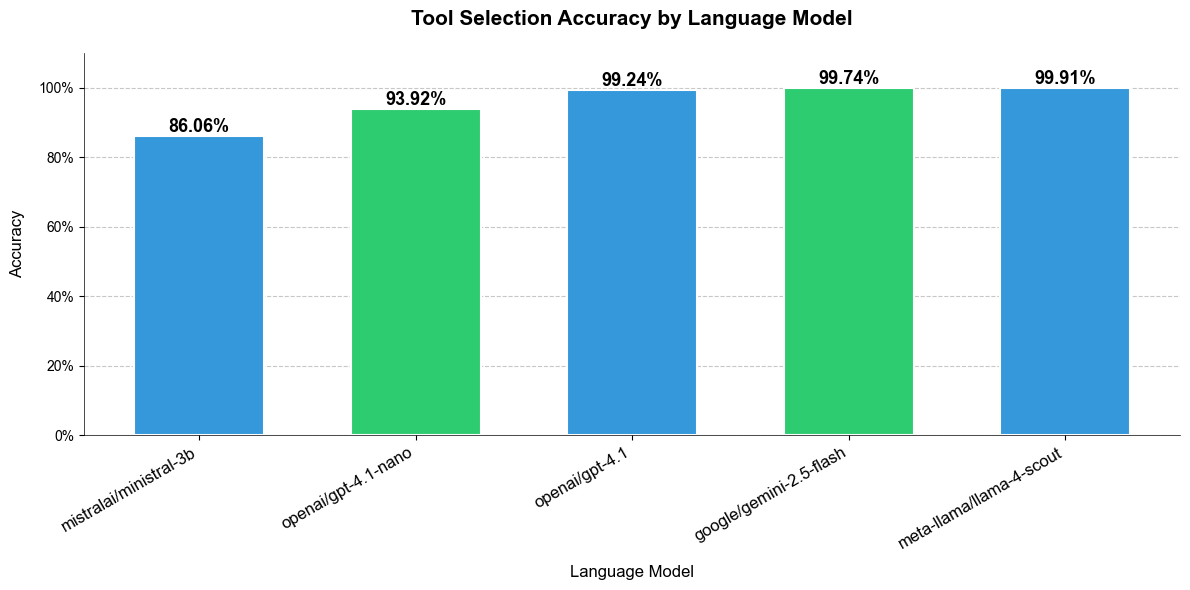

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Set the style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate mean accuracy
mean_accuracy = results_df.groupby('llm')['tool_correct'].mean().sort_values()

# Custom colors with higher saturation
colors = ['#3498db', '#2ecc71']  # Vibrant blue and green

# Create bars
bars = ax.bar(
    mean_accuracy.index,
    mean_accuracy.values,
    color=colors,
    width=0.6,
    edgecolor='white',
    linewidth=1.5
)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:.2%}',
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold'
    )

# Customize the plot
ax.set_title('Tool Selection Accuracy by Language Model', 
             pad=20, 
             fontsize=15, 
             fontweight='bold')
ax.set_xlabel('Language Model', fontsize=12, labelpad=10)
ax.set_ylabel('Accuracy', fontsize=12, labelpad=10)

# Customize grid
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)  # Place gridlines behind bars

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set y-axis limits with some padding
ax.set_ylim(0, min(1.1, max(mean_accuracy.values) * 1.15))

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
# Rotate x-axis labels
ax.set_xticklabels(mean_accuracy.index, rotation=30, ha='right', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig('tool_acc.png', dpi=1000)

In [85]:
# Group by LLM and tool
grouped = results_df.groupby(['llm', 'expected_tool'])

# Compute TP, FP, FN
metrics = []
metrics = []

for llm in results_df['llm'].unique():
    for tool in results_df['expected_tool'].unique():
        df_llm = results_df[results_df['llm'] == llm]

        tp = ((df_llm['first_tool_used_by_agent'] == tool) & (df_llm['expected_tool'] == tool)).sum()
        fp = ((df_llm['first_tool_used_by_agent'] == tool) & (df_llm['expected_tool'] != tool)).sum()
        fn = ((df_llm['first_tool_used_by_agent'] != tool) & (df_llm['expected_tool'] == tool)).sum()

        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0

        metrics.append({
            'llm': llm,
            'tool': tool,
            'precision': precision,
            'recall': recall
        })


metrics_df = pd.DataFrame(metrics)
metrics_df

,llm,tool,precision,recall
0,openai/gpt-4.1-nano,file_storage_tool,0.986842,1.000000
1,openai/gpt-4.1-nano,crypto_and_nft_tool,0.901639,0.916667
2,openai/gpt-4.1-nano,firecrawl_tool,1.000000,0.800000
3,openai/gpt-4.1-nano,translation_tool,1.000000,1.000000
4,openai/gpt-4.1-nano,calendar_scheduling_tool,0.892857,1.000000
...,...,...,...,...
70,openai/gpt-4.1,email_sender_tool,0.000000,0.000000
71,openai/gpt-4.1,python_repl_tool,1.000000,1.000000
72,openai/gpt-4.1,ebay_price_tool,1.000000,1.000000
73,openai/gpt-4.1,google_spreadsheet_tool,1.000000,1.000000


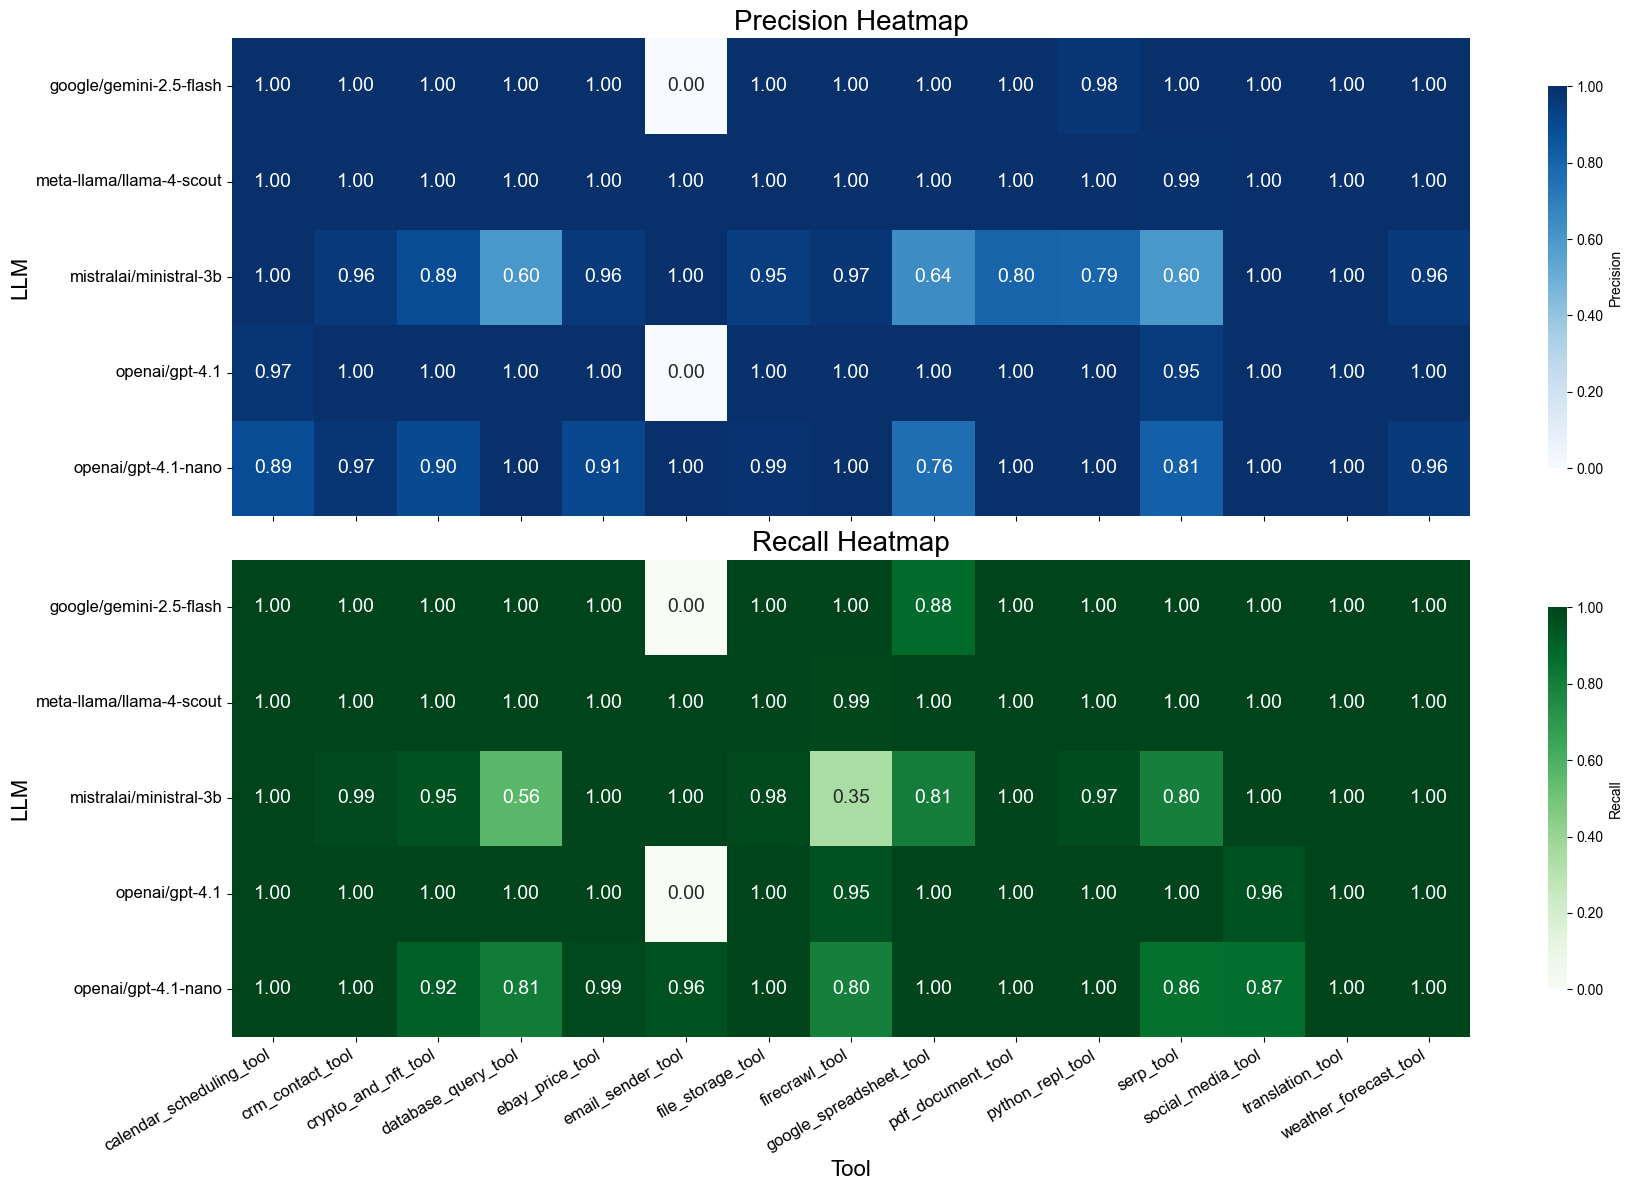

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_precision = metrics_df.pivot(index='llm', columns='tool', values='precision')
pivot_recall = metrics_df.pivot(index='llm', columns='tool', values='recall')

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Precision heatmap
sns.heatmap(
    pivot_precision, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    annot_kws={"fontsize":14},
    cbar_kws={"shrink":0.8, "label": "Precision", "format":'%.2f'},
    ax=axes[0]
)
axes[0].set_title("Precision Heatmap", fontsize=20)
axes[0].set_xlabel("")
axes[0].set_ylabel("LLM", fontsize=16)
axes[0].set_xticklabels(pivot_precision.columns, rotation=30, ha='right', fontsize=12)
axes[0].set_yticklabels(pivot_precision.index, fontsize=12)

# Recall heatmap
sns.heatmap(
    pivot_recall, 
    annot=True, 
    fmt=".2f", 
    cmap="Greens", 
    annot_kws={"fontsize":14},
    cbar_kws={"shrink":0.8, "label": "Recall", "format":'%.2f'},
    ax=axes[1]
)
axes[1].set_title("Recall Heatmap", fontsize=20)
axes[1].set_xlabel("Tool", fontsize=16)
axes[1].set_ylabel("LLM", fontsize=16)
axes[1].set_xticklabels(pivot_recall.columns, rotation=30, ha='right', fontsize=12)
axes[1].set_yticklabels(pivot_recall.index, fontsize=12)

plt.tight_layout()
plt.savefig("precision_recall_heatmaps.png", dpi=300)
plt.show()


In [87]:
results_df[
    (results_df['expected_tool'] == 'serp_tool') & 
    (results_df['tool_correct'] == False)
].sample(10)

,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index,tool_correct
1504,openai/gpt-4.1-nano,Get the latest stock price for Apple (AAPL),google_spreadsheet_tool,"[('google_spreadsheet_tool', '{""action"":""descr...","['ebay_price_tool', 'email_sender_tool', 'weat...",serp_tool,11,8.0,False
1510,openai/gpt-4.1-nano,Get the latest stock price for Apple (AAPL),ebay_price_tool,"[('ebay_price_tool', '{""item_name"":""Apple Inc....","['email_sender_tool', 'database_query_tool', '...",serp_tool,13,6.0,False
1503,openai/gpt-4.1-nano,Get the latest stock price for Apple (AAPL),crypto_and_nft_tool,"[('crypto_and_nft_tool', '{""query"":""Apple stoc...","['database_query_tool', 'firecrawl_tool', 'tra...",serp_tool,10,5.0,False
1161,openai/gpt-4.1-nano,What are the current gas prices in Chicago?,weather_forecast_tool,"[('weather_forecast_tool', '{""location"":""Chica...","['serp_tool', 'file_storage_tool', 'pdf_docume...",serp_tool,0,6.0,False
1174,mistralai/ministral-3b,What are the current gas prices in Chicago?,google_spreadsheet_tool,"[('google_spreadsheet_tool', '{""kwargs"": ""get_...","['firecrawl_tool', 'google_spreadsheet_tool', ...",serp_tool,3,1.0,False
1160,openai/gpt-4.1-nano,What are the current gas prices in Chicago?,weather_forecast_tool,"[('weather_forecast_tool', '{""location"":""Chica...","['email_sender_tool', 'serp_tool', 'firecrawl_...",serp_tool,1,10.0,False
1171,mistralai/ministral-3b,What are the current gas prices in Chicago?,ebay_price_tool,"[('ebay_price_tool', '{""item_name"": ""gas"", ""co...","['weather_forecast_tool', 'pdf_document_tool',...",serp_tool,13,9.0,False
1509,openai/gpt-4.1-nano,Get the latest stock price for Apple (AAPL),google_spreadsheet_tool,"[('google_spreadsheet_tool', '{""action"":""descr...","['firecrawl_tool', 'database_query_tool', 'fil...",serp_tool,8,7.0,False
4485,mistralai/ministral-3b,What are the current gas prices in Chicago?,weather_forecast_tool,"[('weather_forecast_tool', '{""location"": ""Chic...","['crypto_and_nft_tool', 'database_query_tool',...",serp_tool,3,2.0,False
1516,openai/gpt-4.1-nano,Get the latest stock price for Apple (AAPL),crypto_and_nft_tool,"[('crypto_and_nft_tool', '{""query"":""Apple stoc...","['firecrawl_tool', 'social_media_tool', 'pytho...",serp_tool,11,6.0,False


In [88]:
results_df.iloc[2890]['tools_used_by_agent']

'[(\'python_repl_tool\', \'{"code":"\\\\ndef fibonacci_generator():\\\\n    a, b = 0, 1\\\\n    while True:\\\\n        yield a\\\\n        a, b = b, a + b\\\\n\\\\nfib_gen = fibonacci_generator()\\\\nfor _ in range(100):\\\\n    nth_fib = next(fib_gen)\\\\nprint(nth_fib)\\\\n"}\')]'

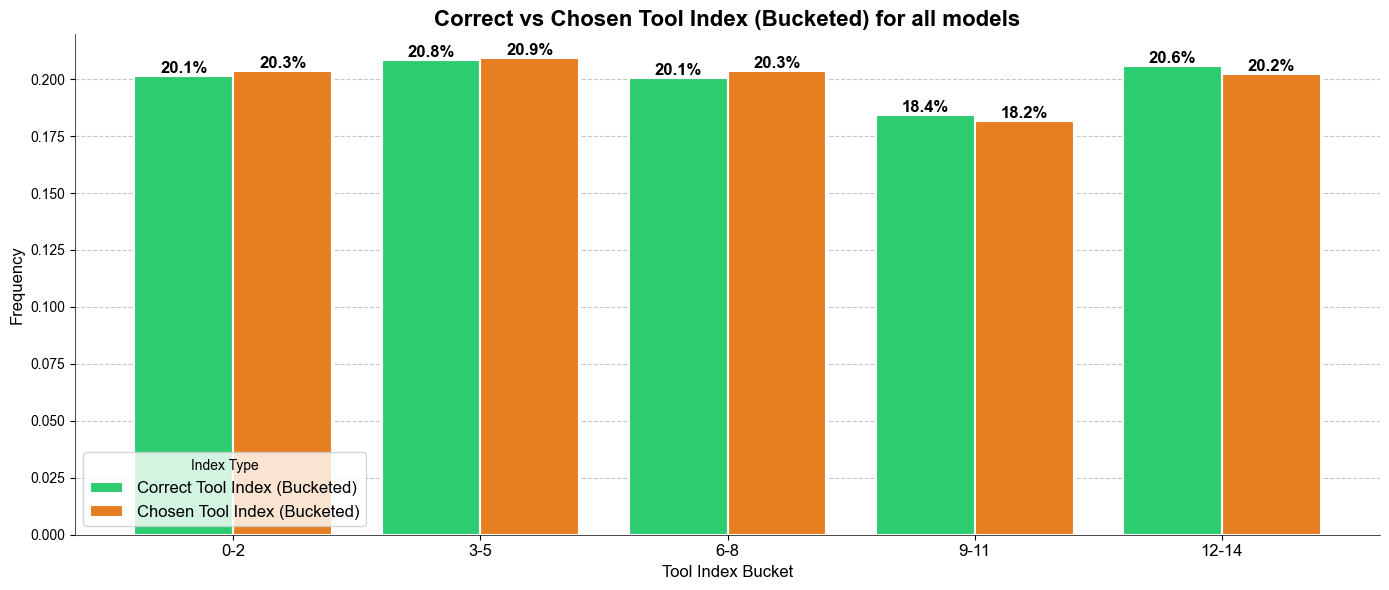

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Define bucket size (same as in other graphs)
bucket_size = 3

# Function to bucket indices
def bucket_index(idx):
    return int(idx) // bucket_size

# Drop NaNs and bucket the indices
correct_buckets = results_df['correct_tool_index'].dropna().astype(int).apply(bucket_index)
chosen_buckets = results_df['chosen_tool_index'].dropna().astype(int).apply(bucket_index)

# Get normalized counts for each bucket
correct_counts_bucketed = correct_buckets.value_counts(normalize=True).sort_index()
chosen_counts_bucketed = chosen_buckets.value_counts(normalize=True).sort_index()

# Align indices
all_buckets = sorted(set(correct_counts_bucketed.index).union(set(chosen_counts_bucketed.index)))
correct_counts_bucketed = correct_counts_bucketed.reindex(all_buckets, fill_value=0)
chosen_counts_bucketed = chosen_counts_bucketed.reindex(all_buckets, fill_value=0)

# Prepare x locations
x = np.arange(len(all_buckets))
bar_width = 0.4

# Plot side-by-side bars with new colors
fig, ax = plt.subplots(figsize=(14, 6))
bars_correct = ax.bar(
    x - bar_width / 2, correct_counts_bucketed, width=bar_width, color='#2ecc71', edgecolor='white', linewidth=1.5, label='Correct Tool Index (Bucketed)'
)
bars_chosen = ax.bar(
    x + bar_width / 2, chosen_counts_bucketed, width=bar_width, color='#e67e22', edgecolor='white', linewidth=1.5, label='Chosen Tool Index (Bucketed)'
)

# Add value labels on top of each bar
for bars in [bars_correct, bars_chosen]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{round(height * 100, 1)}%',
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )

# Customize the plot
ax.set_title(f'Correct vs Chosen Tool Index (Bucketed) for all models', fontsize=16, fontweight='bold')
ax.set_xlabel('Tool Index Bucket', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([f'{i*bucket_size}-{(i+1)*bucket_size-1}' for i in all_buckets], fontsize=12)

# Customize grid and spines
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Add legend
ax.legend(title='Index Type', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


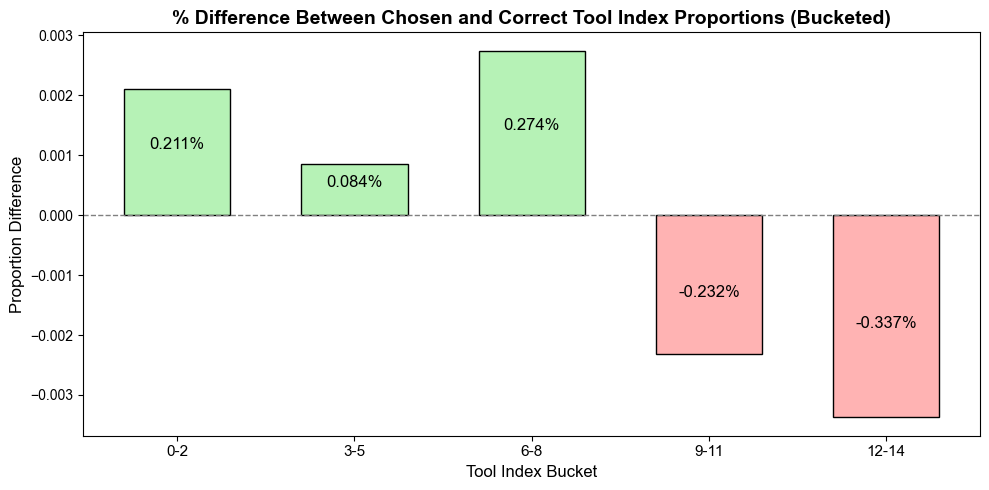

In [93]:
# Define bucket size
bucket_size = 3

# Function to bucket indices
def bucket_index(idx):
    return int(idx) // bucket_size

# Bucket and count correct tool indices
correct_buckets = results_df['correct_tool_index'].dropna().astype(int).apply(bucket_index)
overall_correct_counts_bucketed = correct_buckets.value_counts(normalize=True).sort_index()

# Bucket and count chosen tool indices
chosen_buckets = results_df['chosen_tool_index'].dropna().astype(int).apply(bucket_index)
overall_chosen_counts_bucketed = chosen_buckets.value_counts(normalize=True).sort_index()
import matplotlib.pyplot as plt
import numpy as np

# Calculate the difference
bucket_diff = overall_chosen_counts_bucketed - overall_correct_counts_bucketed

# Choose colors: light green for positive, light red for negative
bar_colors = ['#b6f2b6' if v >= 0 else '#ffb3b3' for v in bucket_diff]

# Plot the difference
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(bucket_diff))
ax.bar(x, bucket_diff, color=bar_colors, edgecolor='black', width=0.6)

ax.set_title('% Difference Between Chosen and Correct Tool Index Proportions (Bucketed)', fontsize=14, fontweight='bold')
ax.set_xlabel('Tool Index Bucket', fontsize=12)
ax.set_ylabel('Proportion Difference', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([f'{i*bucket_size}-{(i+1)*bucket_size-1}' for i in x], fontsize=11)

# Add value labels
for i, v in enumerate(bucket_diff):
    ax.text(i, v + (-abs(v) / 2 if v >= 0 else abs(v) / 2), f'{v * 100:.3f}%', ha='center', va='bottom' if v >= 0 else 'top', fontsize=12)

ax.axhline(0, color='gray', linewidth=1, linestyle='--')
plt.tight_layout()
plt.savefig('bucketed_tool_index_difference.png', dpi=300)
plt.show()

In [94]:
overall_chosen_counts_bucketed, overall_correct_counts_bucketed

(chosen_tool_index
 0    0.203458
 1    0.209150
 2    0.203458
 3    0.181742
 4    0.202193
 Name: proportion, dtype: float64,
 correct_tool_index
 0    0.201349
 1    0.208307
 2    0.200717
 3    0.184061
 4    0.205566
 Name: proportion, dtype: float64)

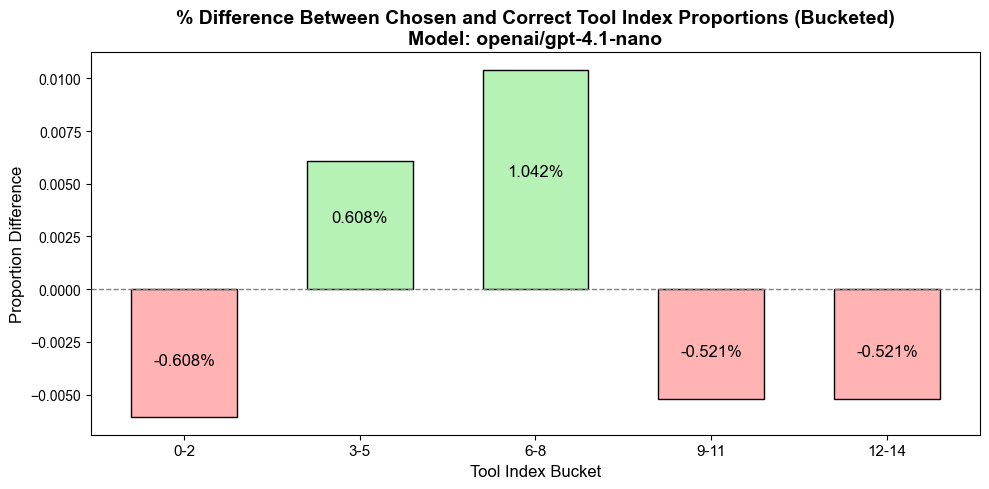

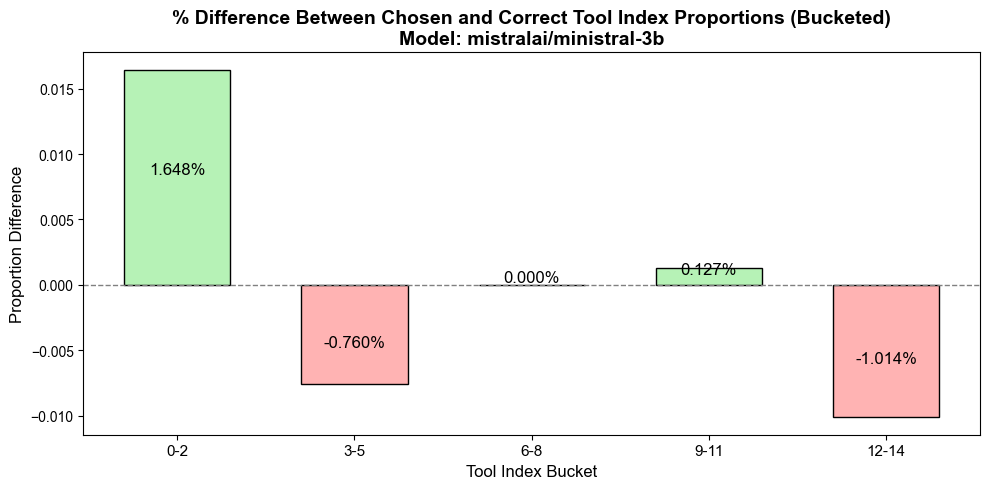

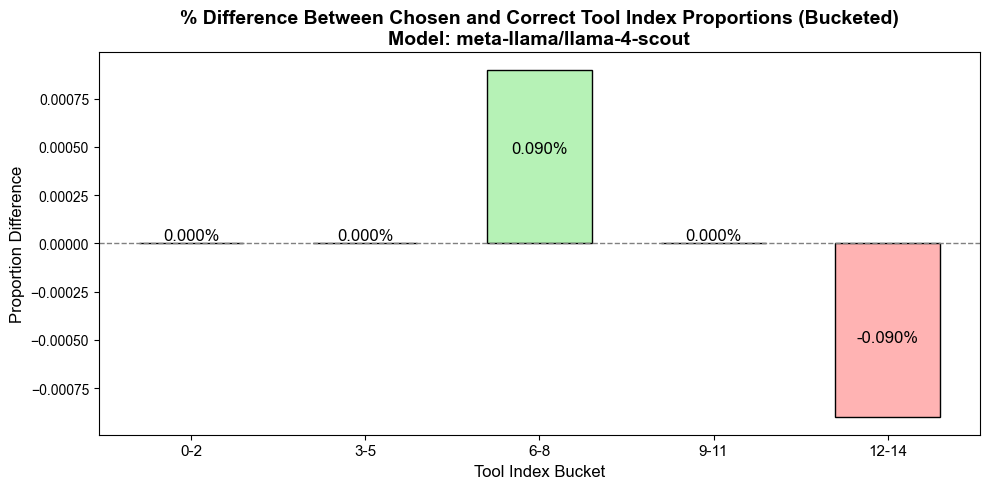

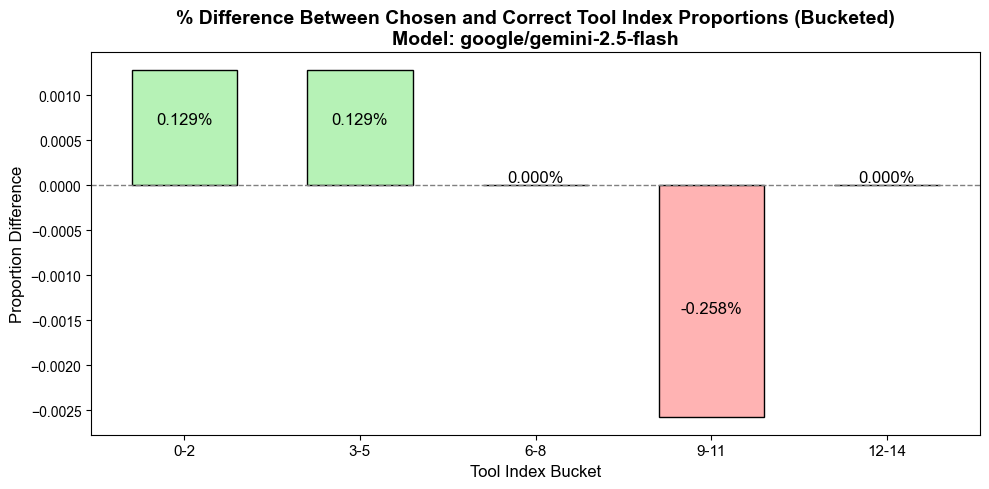

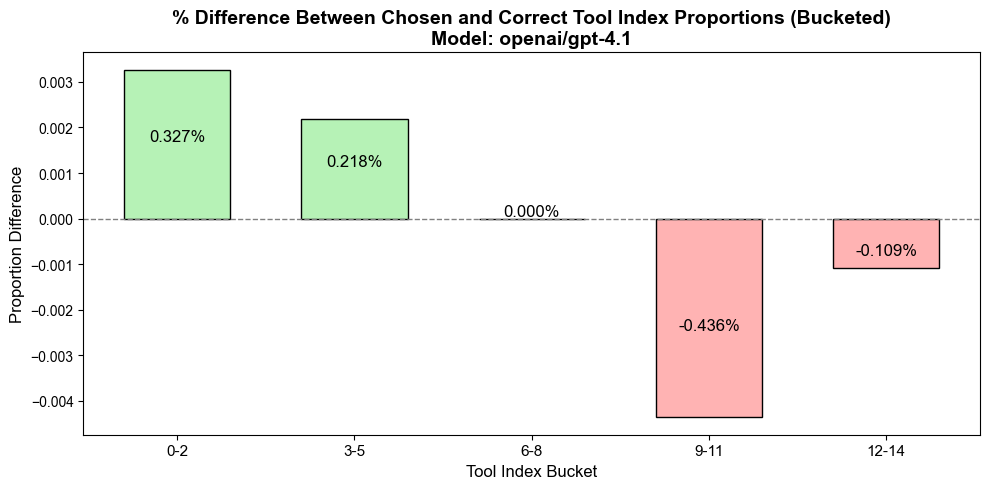

In [91]:
import matplotlib.pyplot as plt
import numpy as np

bucket_size = 3

for MODEL_NAME in results_df['llm'].unique():
    llm_results = results_df[results_df['llm'] == MODEL_NAME].dropna(subset=['correct_tool_index', 'chosen_tool_index'])
    
    # Bucket and count correct tool indices
    correct_buckets = llm_results['correct_tool_index'].astype(int).apply(lambda idx: int(idx) // bucket_size)
    correct_counts_bucketed = correct_buckets.value_counts(normalize=True).sort_index()
    
    # Bucket and count chosen tool indices
    chosen_buckets = llm_results['chosen_tool_index'].astype(int).apply(lambda idx: int(idx) // bucket_size)
    chosen_counts_bucketed = chosen_buckets.value_counts(normalize=True).sort_index()
    
    # Align indices
    all_buckets = sorted(set(correct_counts_bucketed.index).union(set(chosen_counts_bucketed.index)))
    correct_counts_bucketed = correct_counts_bucketed.reindex(all_buckets, fill_value=0)
    chosen_counts_bucketed = chosen_counts_bucketed.reindex(all_buckets, fill_value=0)
    bucket_diff = chosen_counts_bucketed - correct_counts_bucketed

    bar_colors = ['#b6f2b6' if v >= 0 else '#ffb3b3' for v in bucket_diff]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(all_buckets))
    ax.bar(x, bucket_diff, color=bar_colors, edgecolor='black', width=0.6)

    ax.set_title(f'% Difference Between Chosen and Correct Tool Index Proportions (Bucketed)\nModel: {MODEL_NAME}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Tool Index Bucket', fontsize=12)
    ax.set_ylabel('Proportion Difference', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{i*bucket_size}-{(i+1)*bucket_size-1}' for i in all_buckets], fontsize=11)

    # Add value labels
    for i, v in enumerate(bucket_diff):
        ax.text(i, v + (-abs(v) / 2 if v >= 0 else abs(v) / 2), f'{v * 100:.3f}%', ha='center', va='bottom' if v >= 0 else 'top', fontsize=12)

    ax.axhline(0, color='gray', linewidth=1, linestyle='--')
    plt.tight_layout()
    plt.savefig(f'bucketed_tool_index_difference_{MODEL_NAME.replace("/", "_")}.png', dpi=300)
    plt.show()


In [ ]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(
    model="moonshotai/kimi-k2", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"],
   reasoning_effort='high'
    )

In [ ]:
response = llm.invoke(
    [{"role": "user", "content": "hi"}],
    reasoning={
        "enabled": True
    }
)

TypeError: Responses.create() got an unexpected keyword argument 'reasoning_effort'

In [ ]:
response

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 26, 'total_tokens': 36, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshotai/kimi-k2', 'system_fingerprint': 'fp_c5bd0a648b', 'id': 'gen-1754517000-aJDrjSpPAuXNr9ZkpIYu', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--35d286e0-9c0f-4476-a6d2-3d6aaee8b949-0', usage_metadata={'input_tokens': 26, 'output_tokens': 10, 'total_tokens': 36, 'input_token_details': {}, 'output_token_details': {}})

In [186]:
print(response.content)

Hello! How can I help you today?


In [5]:
response = llm.invoke(
    [{"role": "user", "content": "hi"}, {"role": "assistant", "content": "Hello! How can I help you today?"}, {"role": "user", "content": "How many r’s are in the word supercalifragilisticexpialidocious?"}],
    # reasoning={
    #     "enabled": True
    # }
)

In [6]:
print(response.content)

Alright, let's tackle the question: **How many r's are in the word "supercalifragilisticexpialidocious"?**

### Understanding the Problem
First, I need to understand what the question is asking. It's not about the meaning or the length of the word, but simply counting how many times the letter 'r' (both uppercase and lowercase, though here it's all lowercase) appears in the word "supercalifragilisticexpialidocious".

### Breaking Down the Word
The given word is: **supercalifragilisticexpialidocious**

To accurately count the number of 'r's, I'll go through each letter of the word one by one.

Let's write down the word and assign positions to each letter to keep track:

1. s
2. u
3. p
4. e
5. r
6. c
7. a
8. l
9. i
10. f
11. r
12. a
13. g
14. i
15. l
16. i
17. s
18. t
19. i
20. c
21. e
22. x
23. p
24. i
25. a
26. l
27. i
28. d
29. o
30. c
31. i
32. o
33. u
34. s

### Identifying 'r's
Now, I'll scan each letter to see if it's an 'r':

- Position 1: s → not r
- Position 2: u → not r
- Posi

In [ ]:
from langchain_openai import ChatOpenAI
import os
llm = ChatOpenAI(
    model="deepseek/deepseek-r1-0528", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"],
    reasoning_effort='high',
    include_reasoning=True
    )

response = llm.invoke(
    [{"role": "user", "content": "hi"}],
    
    )
    
print(response.content)

Alright, let's tackle this problem step by step. The question is asking how many times the letter 'r' appears in the word "supercalifragilisticexpialidocious." 

### Understanding the Problem
First, I need to write down the word clearly to examine each letter. The word is:

**s u p e r c a l i f r a g i l i s t i c e x p i a l i d o c i o u s**

Our goal is to count every occurrence of the lowercase letter 'r' in this sequence.

### Breaking Down the Word
Let's list out each letter one by one and note the positions where 'r' appears.

Here’s the word again with positions (for clarity, though we might not need positions):

1. s
2. u
3. p
4. e
5. r
6. c
7. a
8. l
9. i
10. f
11. r
12. a
13. g
14. i
15. l
16. i
17. s
18. t
19. i
20. c
21. e
22. x
23. p
24. i
25. a
26. l
27. i
28. d
29. o
30. c
31. i
32. o
33. u
34. s

### Identifying 'r's
Now, let's scan each letter for 'r':

- Position 5: r (1st 'r')
- Position 11: r (2nd 'r')

Looking through the rest of the letters:

From position 12 to

In [ ]:
import os
os.environ["OPENROUTER_API_KEY"] = "your-openrouter-api-key-here"

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_43084/809242427.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x="Language Model", y="Accuracy", data=df, palette=colors)


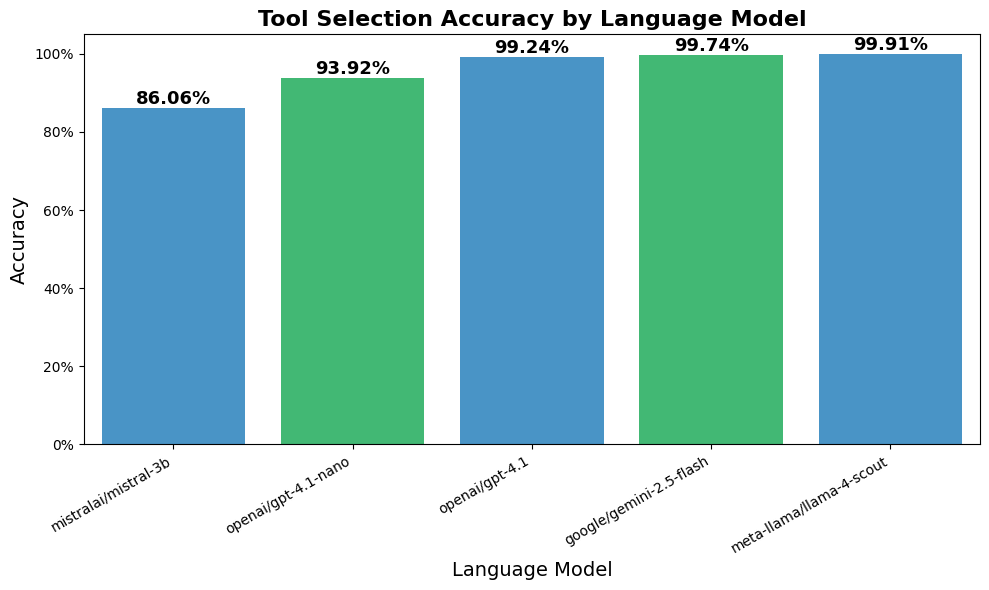

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Language Model": [
        "mistralai/mistral-3b",
        "openai/gpt-4.1-nano",
        "openai/gpt-4.1",
        "google/gemini-2.5-flash",
        "meta-llama/llama-4-scout"
    ],
    "Accuracy": [86.06, 93.92, 99.24, 99.74, 99.91]
}

df = pd.DataFrame(data)

# Color scheme: alternating like the image
colors = ["#3498db", "#2ecc71", "#3498db", "#2ecc71", "#3498db"]

# Plot
plt.figure(figsize=(10, 6))
bars = sns.barplot(x="Language Model", y="Accuracy", data=df, palette=colors)

# Add percentage labels on top of each bar
for p in bars.patches:
    bars.annotate(
        f"{p.get_height():.2f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=13, fontweight='bold'
    )

# Titles and labels
plt.title("Tool Selection Accuracy by Language Model", fontsize=16, fontweight='bold')
plt.xlabel("Language Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Make y-axis a percentage
plt.ylim(0, 105)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}%'))

# Rotate x-axis labels
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.savefig("tool_selection_accuracy_by_language_model___1.png", dpi=300)
plt.show()
